In [26]:

import os
import cv2
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, Flatten, Input, Dropout
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications import VGG16

In [27]:
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "C:\\Abhishek_Data\\My_Data\\Datasets\\Detection\\od_notebooks\\dataset2"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

In [28]:
csvPaths = []
for (rootDir, dirNames, filenames) in os.walk(ANNOTS_PATH):
    # loop over the filenames in the current directory
    for filename in filenames:
        # determine the file extension of the current file
        ext = filename[filename.rfind("."):].lower()

        # check to see if the file is an image and should be processed
        if ext.endswith(".csv"):
            # construct the path to the image and yield it
            csvPath = os.path.join(rootDir, filename)
            csvPaths.append(csvPath)

In [29]:
# initialize the list of data (images), class labels,
# target bounding box coordinates, and image paths
data = []
labels = []
bboxes = []
imagePaths = []

# loop over all CSV files in the annotations directory
for csvPath in csvPaths:
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")

    # loop over the rows
    for row in rows:
        # break the row into the filename, bounding box coordinates,
        # and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

In [30]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [31]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [32]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [33]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

# initialize the optimizer, compile the model, and show the model summary
model.compile(loss=losses, optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"], loss_weights=lossWeights)

In [34]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

# model training (adding and retraining top classification layers not fine tuning)
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# train the network for bounding box regression and class label prediction
history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback])

Epoch 1/20
51/51 [==============================] - 264s 5s/step - loss: 0.2057 - bounding_box_loss: 0.0111 - class_label_loss: 0.1946 - bounding_box_accuracy: 0.7042 - class_label_accuracy: 0.9268 - val_loss: 0.0072 - val_bounding_box_loss: 0.0016 - val_class_label_loss: 0.0057 - val_bounding_box_accuracy: 0.8894 - val_class_label_accuracy: 0.9975
Epoch 2/20
51/51 [==============================] - 247s 5s/step - loss: 0.0125 - bounding_box_loss: 0.0013 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.8653 - class_label_accuracy: 0.9951 - val_loss: 0.0040 - val_bounding_box_loss: 0.0013 - val_class_label_loss: 0.0027 - val_bounding_box_accuracy: 0.8747 - val_class_label_accuracy: 0.9975
Epoch 3/20
51/51 [==============================] - 244s 5s/step - loss: 0.0103 - bounding_box_loss: 9.1032e-04 - class_label_loss: 0.0094 - bounding_box_accuracy: 0.8690 - class_label_accuracy: 0.9982 - val_loss: 0.0023 - val_bounding_box_loss: 0.0011 - val_class_label_loss: 0.0012 - val_bounding

In [37]:
model.save('02_regression_classification.h5', save_format="h5")
with open('box_reg_class.pickle', "wb") as f:
    f.write(pickle.dumps(lb))

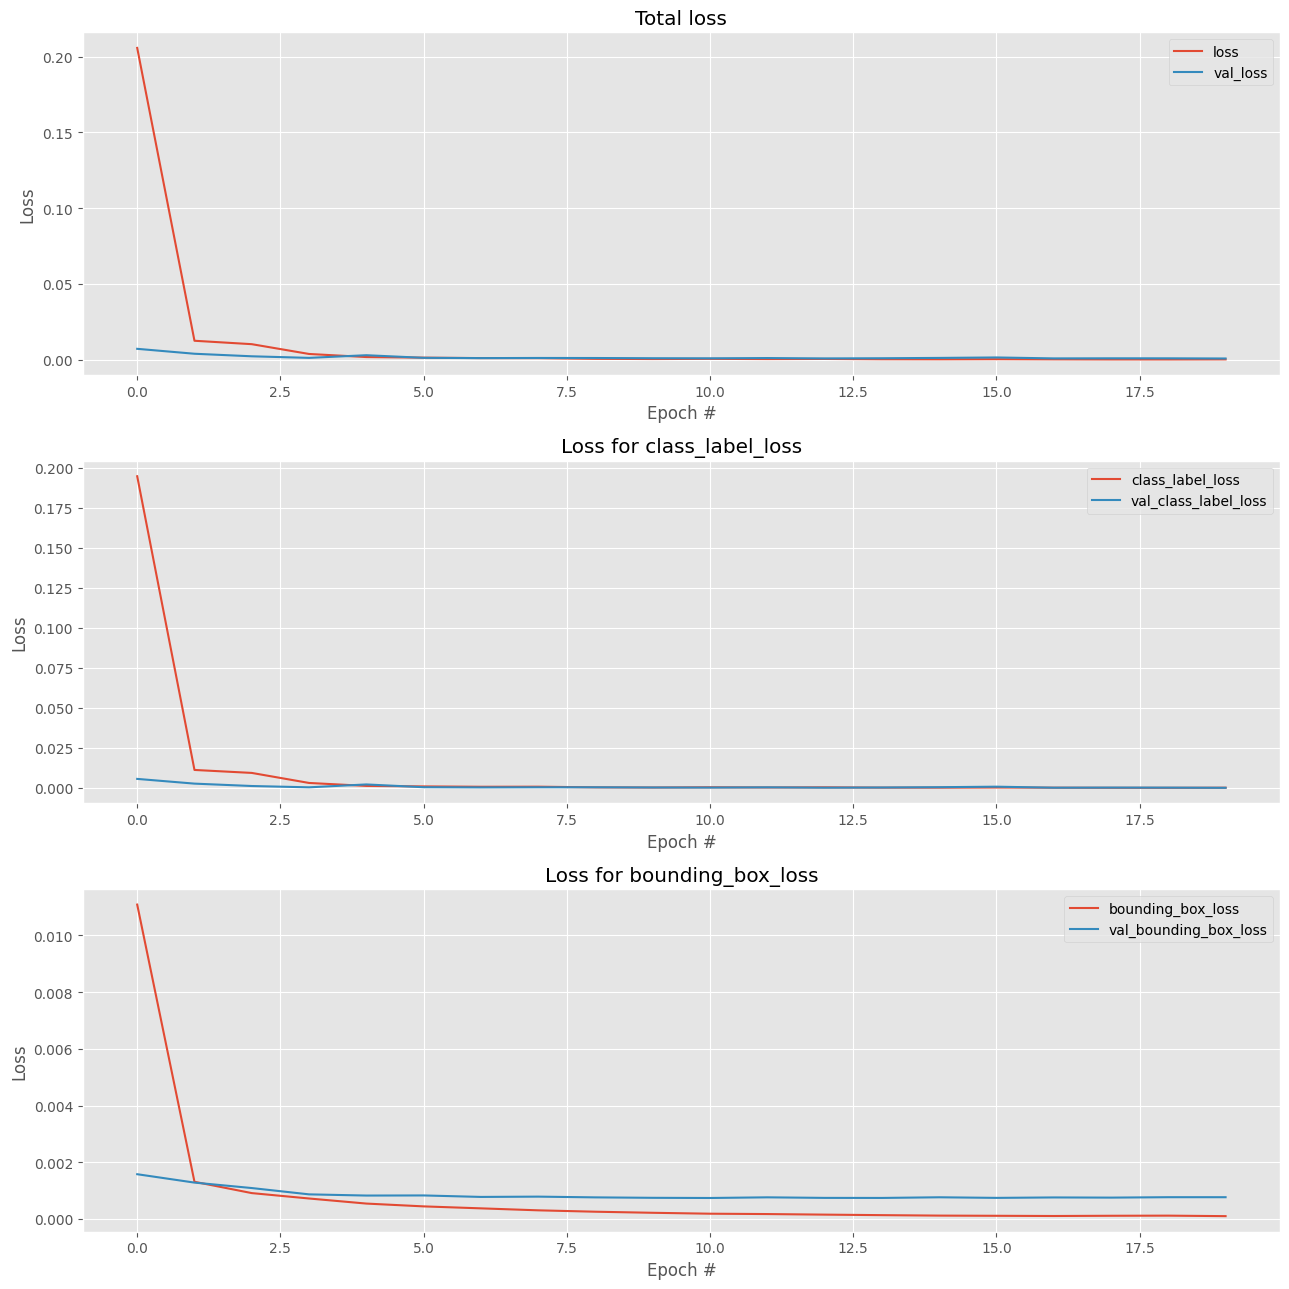

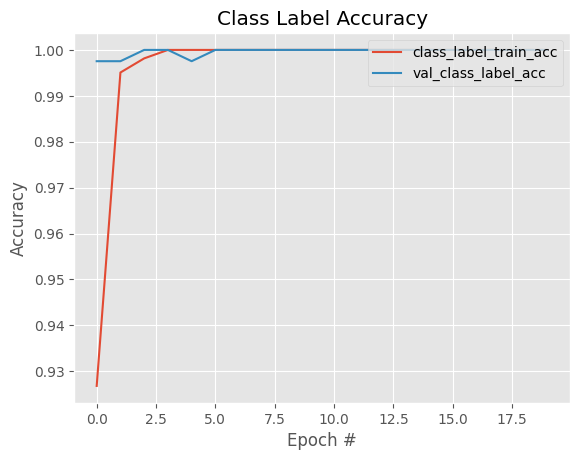

In [38]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, history.params['epochs'])
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, history.history[l], label=l)
    ax[i].plot(N, history.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["class_label_accuracy"], label="class_label_train_acc")
plt.plot(N, history.history["val_class_label_accuracy"], label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")

In [39]:
from keras.models import load_model
model = load_model('03_regression_classification.h5')
lb = pickle.loads(open('box_reg_class.pickle', "rb").read())

In [40]:
def inference(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return model.predict(image)

In [41]:
def draw_bbox(img, boxPreds, labelPreds):
    image = np.copy(img)
    (h, w) = image.shape[:2]
    
    # predict the bounding box of the object along with the class label
    (startX, startY, endX, endY) = boxPreds[0]

    # determine the class label with the largest predicted probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    
    return image

1/1 [==============================] - 0s 153ms/step


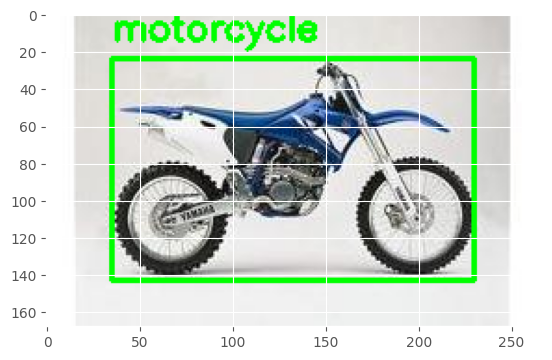

In [45]:
imagePath='C:\\Abhishek_Data\\My_Data\\Datasets\\Detection\\od_notebooks\\dataset2\\images\\motorcycle\\image_0063.jpg'
image = plt.imread(imagePath)
(boxPreds, labelPreds) = inference(imagePath)
image_with_bbox = draw_bbox(image, boxPreds, labelPreds)
plt.imshow(image_with_bbox)